# HW 02: BMW vs Volkswagen por Román Merino

### Instalación de Librerías

In [1]:
! pip install yfinance

In [2]:
! pip install arch

In [43]:
! pip install quandl

### Importación de los paquetes necesarios

In [51]:
import yfinance as yf
import pandas as pd
import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from sktime.forecasting.model_selection import temporal_train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.tsa.base.datetools import dates_from_str
import scipy
from arch import arch_model
import quandl as q

import warnings
warnings.filterwarnings('ignore')

### Importación de los datos

In [4]:
BMW_ticker = yf.Ticker("BMW.DE")
VW_ticker = yf.Ticker("VOW.DE")
BMW=BMW_ticker.history(period="max")
VW=VW_ticker.history(period="max")
BMW.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1996-11-08 00:00:00+01:00,9.353777,9.353777,9.333744,9.333744,767000,0.0,0
1996-11-11 00:00:00+01:00,9.343508,9.348645,9.288033,9.308578,260000,0.0,0
1996-11-12 00:00:00+01:00,9.328610,9.414391,9.293167,9.378949,1066000,0.0,0
1996-11-13 00:00:00+01:00,9.422611,9.422611,9.343508,9.364054,793000,0.0,0
1996-11-14 00:00:00+01:00,9.351211,9.394359,9.313714,9.394359,351000,0.0,0


In [5]:
BMW_mensual=BMW
BMW_mensual=BMW_mensual.reset_index()
BMW_mensual['Date'] = BMW_mensual['Date'].apply(lambda x: x.strftime('%Y-%m-%d')).apply(pd.to_datetime)
BMW_mensual = BMW_mensual.resample('M', on='Date').mean().round(2)

VW_mensual=VW
VW_mensual=VW_mensual.reset_index()
VW_mensual['Date'] = VW_mensual['Date'].apply(lambda x: x.strftime('%Y-%m-%d')).apply(pd.to_datetime)
VW_mensual = VW_mensual.resample('M', on='Date').mean().round(2)

# 1. Estima un modelo VAR mensual entre los dos activos. (Muestra:2009/01 a 2020/10)


In [6]:
BMW_train=BMW_mensual['2009-01':'2020-10']
BMW_test = BMW_mensual['2020-10':]
VW_train=VW_mensual['2009-01':'2020-10']
VW_test = VW_mensual['2020-10':]

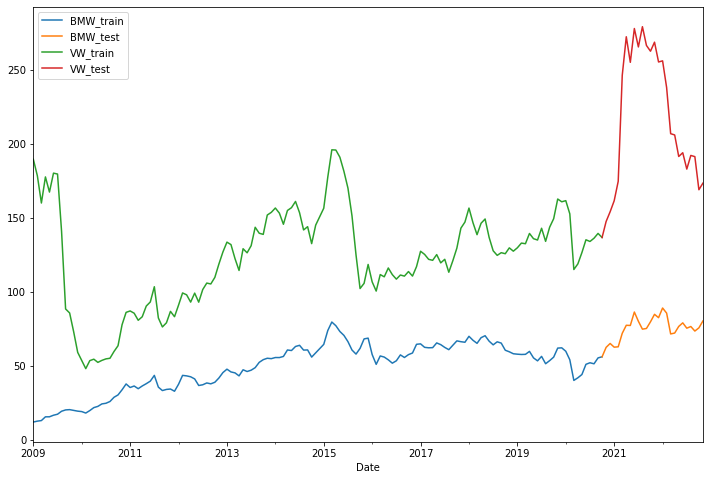

In [7]:
BMW_train['Close'].plot(legend=True,label='BMW_train',figsize=(12,8))
BMW_test['Close'].plot(legend=True,label='BMW_test',figsize=(12,8));
VW_train['Close'].plot(legend=True,label='VW_train',figsize=(12,8))
VW_test['Close'].plot(legend=True,label='VW_test',figsize=(12,8));

In [8]:
data=pd.merge(BMW_mensual['Close'], VW_mensual['Close'], left_index=True, right_index=True)
data.rename(columns = {'Close_x':'Close_BMW','Close_y': 'Close_VW'}, inplace = True)
muestra=data['2009-01-01':'2020-10-01']
train, test = temporal_train_test_split(y = muestra, test_size=8)

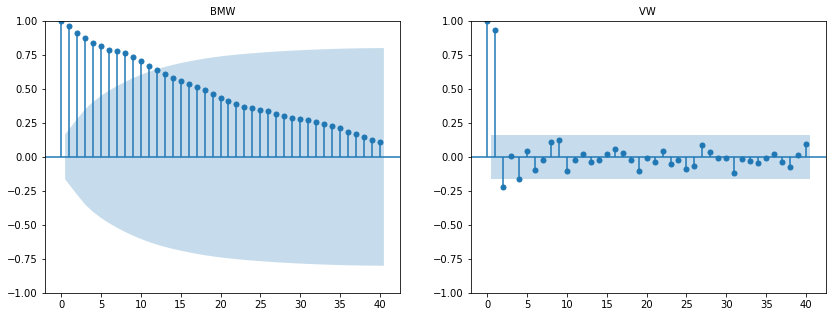

In [9]:
plt.close()
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plot_acf(BMW_train['Close'], lags=40, ax=ax1)
ax1.set_title('BMW', fontsize=10)
plot_pacf(VW_train['Close'], lags=40, method='ywm', ax=ax2)
ax2.set_title('VW ', fontsize=10)
plt.show()
plt.close()

## MODELO VAR

In [10]:
# definir el VAR
model = VAR(data)
# maximo lag a seleccionar
model.select_order(30)

In [11]:
# estimar los modelos y seleccionar
results = model.fit(maxlags=30, ic='aic')

In [12]:
# lag con menor AIC
results.k_ar

13

In [13]:
# El modelo estimado
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 02, Nov, 2022
Time:                     10:23:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.12501
Nobs:                     300.000    HQIC:                   6.72514
Log likelihood:          -1766.11    FPE:                    638.618
AIC:                      6.45833    Det(Omega_mle):         537.512
--------------------------------------------------------------------
Results for equation Close_BMW
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.289678         0.308320            0.940           0.347
L1.Close_BMW          1.355056         0.069217           19.577           0.000
L1.Close_VW          -0.032857         0.017185         

# 2. ¿Cuál es la predicción para octubre de 2021 de los dos activos?. ¿Son buenas predicciones?

Mirarlo para Octubre. Enlace ejercicio 5

In [14]:
lag_order = results.k_ar
lag_order

13

In [15]:
data.values[-lag_order:]

array([[ 84.69, 268.63],
       [ 82.42, 255.25],
       [ 88.96, 256.01],
       [ 85.51, 237.98],
       [ 71.43, 206.78],
       [ 72.04, 205.92],
       [ 76.5 , 191.37],
       [ 78.92, 193.91],
       [ 75.32, 182.85],
       [ 76.45, 192.08],
       [ 73.38, 191.27],
       [ 75.53, 168.9 ],
       [ 80.19, 173.35]])

In [16]:
# Hacemos 10 predicciones
results.forecast(data.values[-lag_order:], 10)

array([[ 78.66697494, 179.18249006],
       [ 76.89647615, 169.55574909],
       [ 78.18088867, 171.46390237],
       [ 81.28593575, 186.38539945],
       [ 80.62202866, 187.3483221 ],
       [ 80.83084957, 187.37693242],
       [ 81.44965406, 183.56957841],
       [ 81.774788  , 180.11591123],
       [ 81.1902602 , 183.70303623],
       [ 81.45105224, 191.21194865]])

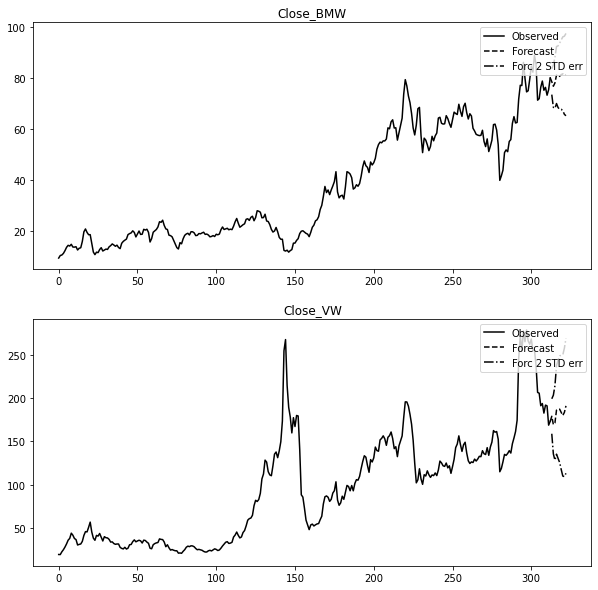

In [17]:
results.plot_forecast(10);

In [18]:
f_data=train.values[-1:]+results.forecast(data.values[-lag_order:], 8)
f_data

array([[138.39697494, 340.69249006],
       [136.62647615, 331.06574909],
       [137.91088867, 332.97390237],
       [141.01593575, 347.89539945],
       [140.35202866, 348.8583221 ],
       [140.56084957, 348.88693242],
       [141.17965406, 345.07957841],
       [141.504788  , 341.62591123]])

In [19]:
data_fore=pd.DataFrame(f_data)
data_fore.index=test.index
data_fore.rename(columns={0: 'BMW', 1: 'VW'}, inplace=True)
data_fore

,BMW,VW
Date,,
2020-02-29,138.396975,340.692490
2020-03-31,136.626476,331.065749
2020-04-30,137.910889,332.973902
2020-05-31,141.015936,347.895399
2020-06-30,140.352029,348.858322
2020-07-31,140.560850,348.886932
2020-08-31,141.179654,345.079578
2020-09-30,141.504788,341.625911


Predicción normal

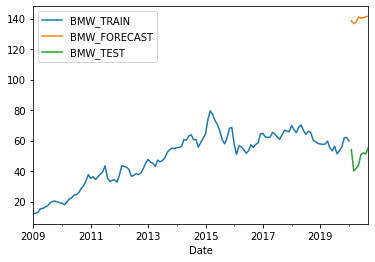

In [20]:
train['Close_BMW'].plot(legend=True,label='BMW_TRAIN',)
data_fore['BMW'].plot(legend=True,label='BMW_FORECAST')
test['Close_BMW'].plot(legend=True,label='BMW_TEST');

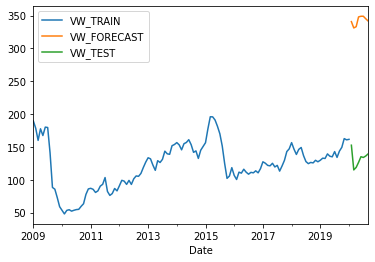

In [21]:
train['Close_VW'].plot(legend=True,label='VW_TRAIN',)
data_fore['VW'].plot(legend=True,label='VW_FORECAST')
test['Close_VW'].plot(legend=True,label='VW_TEST');

Predicción para octubre de 2021

In [22]:
muestra2=data['2021-10-01':'2021-12-01']
train2, test2 = temporal_train_test_split(y = muestra2, test_size=1)

In [23]:
f_data2=train2.values[-1:]+results.forecast(data.values[-lag_order:], 8)
f_data2

array([[158.29697494, 441.70249006],
       [156.52647615, 432.07574909],
       [157.81088867, 433.98390237],
       [160.91593575, 448.90539945],
       [160.25202866, 449.8683221 ],
       [160.46084957, 449.89693242],
       [161.07965406, 446.08957841],
       [161.404788  , 442.63591123]])

In [24]:
data_fore2=pd.DataFrame(f_data2)
data_fore2.index=test.index
data_fore2.rename(columns={0: 'BMW', 1: 'VW'}, inplace=True)
data_fore2

,BMW,VW
Date,,
2020-02-29,158.296975,441.702490
2020-03-31,156.526476,432.075749
2020-04-30,157.810889,433.983902
2020-05-31,160.915936,448.905399
2020-06-30,160.252029,449.868322
2020-07-31,160.460850,449.896932
2020-08-31,161.079654,446.089578
2020-09-30,161.404788,442.635911


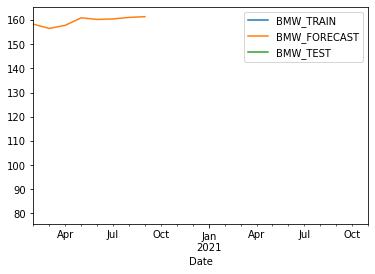

In [25]:
train2['Close_BMW'].plot(legend=True,label='BMW_TRAIN',)
data_fore2['BMW'].plot(legend=True,label='BMW_FORECAST')
test2['Close_BMW'].plot(legend=True,label='BMW_TEST');

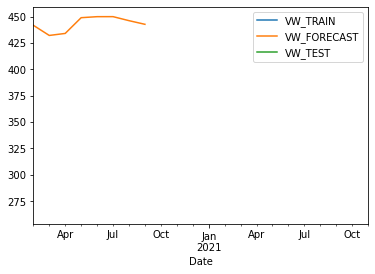

In [26]:
train2['Close_VW'].plot(legend=True,label='VW_TRAIN',)
data_fore2['VW'].plot(legend=True,label='VW_FORECAST')
test2['Close_VW'].plot(legend=True,label='VW_TEST');

En las dos gráficas de predicción para octubre podemos observar como va siendo hasta octubre de 2021. Para BMW es favorable ya que se mantiene constante en incluso parece que crece un poco. Para Volkswagen la predicción es peor ya que tiene altibajos y para octubre se ve que empezará a caer.

# 3. ¿Cuál de los dos activos es el lider y cual es el seguidor?

Si nos fijamos en las gráficas de train, forecast y test, de la predicción normal, podemos deducir que el lider es BMW y que Volkswagen es el seguidor, ya que Volkswagen tiene muchas subidas y bajadas y BMW crece de manera constante.

# 4. ¿Es la Volatilidad de BMW constante? Estimar el modelo garch de BMW (Muestra: Toda la disponible en Yahoo hasta el 31/10/2020)

In [27]:
market = BMW["Close"]
returns = 100 * market.pct_change().dropna()

In [28]:
am = arch_model(returns)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     33,   Neg. LLF: 13691.070633297471
Iteration:     10,   Func. Count:     62,   Neg. LLF: 13658.94901481735
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13658.93319132337
            Iterations: 14
            Function evaluations: 81
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13658.9
Distribution:                  Normal   AIC:                           27325.9
Method:            Maximum Likelihood   BIC:                           27353.1
                                        No. Observations:                 6661
Date:                Wed, Nov 02 2022   Df Residuals:                     6660
Time:         

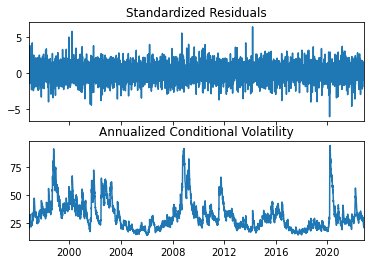

In [29]:
fig = res.plot(annualize="D")

Como podemos observar en el gráfico Annualized Conditional Volatility, la volatilidad no es constante

# 5. ¿Cuál es la predicción para el mes de noviembre de 2020? ¿Son buenas predicciones?


In [30]:
muestra3=data['2020-11-01':'2021-01-01']
train3, test3 = temporal_train_test_split(y = muestra3, test_size=1)

In [31]:
f_data3=train3.values[-1:]+results.forecast(data.values[-lag_order:], 8)
f_data3

array([[141.02697494, 326.61249006],
       [139.25647615, 316.98574909],
       [140.54088867, 318.89390237],
       [143.64593575, 333.81539945],
       [142.98202866, 334.7783221 ],
       [143.19084957, 334.80693242],
       [143.80965406, 330.99957841],
       [144.134788  , 327.54591123]])

In [32]:
data_fore3=pd.DataFrame(f_data2)
data_fore3.index=test.index
data_fore3.rename(columns={0: 'BMW', 1: 'VW'}, inplace=True)
data_fore3

,BMW,VW
Date,,
2020-02-29,158.296975,441.702490
2020-03-31,156.526476,432.075749
2020-04-30,157.810889,433.983902
2020-05-31,160.915936,448.905399
2020-06-30,160.252029,449.868322
2020-07-31,160.460850,449.896932
2020-08-31,161.079654,446.089578
2020-09-30,161.404788,442.635911


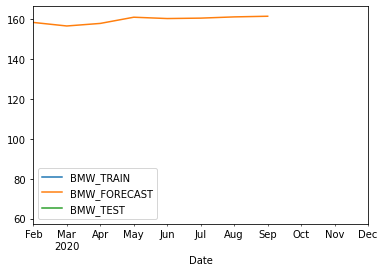

In [33]:
train3['Close_BMW'].plot(legend=True,label='BMW_TRAIN',)
data_fore3['BMW'].plot(legend=True,label='BMW_FORECAST')
test3['Close_BMW'].plot(legend=True,label='BMW_TEST');

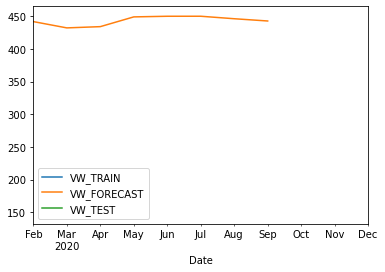

In [34]:
train3['Close_VW'].plot(legend=True,label='VW_TRAIN',)
data_fore3['VW'].plot(legend=True,label='VW_FORECAST')
test3['Close_VW'].plot(legend=True,label='VW_TEST');

Las predicciones para ambos activos parecen favorables. Ambos se mantienen constantes en el tiempo, salvo que la predicción de Volkswagen tienen un poco de pendiente negativa.

# 6. Plantea un sistema de trading diario para BMW a partir del modelo Garch para el mes de noviembre de 2020. ¿Es rentable?

In [88]:
BMW_data = BMW_mensual.get("Close")

In [98]:
BMW_data

Date
1996-11-30 00:00:00       9.57
1996-12-31 00:00:00      10.57
1997-01-31 00:00:00      10.76
1997-02-28 00:00:00      11.40
1997-03-31 00:00:00      12.48
                        ...   
2022-08-31 00:00:00      76.45
2022-09-30 00:00:00      73.38
2022-10-31 00:00:00      75.53
2022-11-30 00:00:00      80.19
Date                   2008.00
Name: Close, Length: 314, dtype: float64

In [100]:
BMW_trading = BMW_data['Date'] = 2020-11-1

In [101]:
BMW_trading

2008

In [102]:
BMW_data.describe()

count     314.000000
mean       43.142357
std       113.359726
min         9.570000
25%        18.777500
50%        25.385000
75%        57.540000
max      2008.000000
Name: Close, dtype: float64

Es rentable ya que coincide el BMW_trading con el max de BMW_data.